## Setup

In [1]:
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

# Turn off TensorFlow logging messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["PYTHONHASHSEED"] = "0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 100)

## Task: Sentiment Classification

We use the IMDB movie reviews dataset. The task is to classify each review as:

* **POSITIVE (1)**: Reviews expressing positive sentiment about the movie
* **NEGATIVE (0)**: Reviews expressing negative sentiment about the movie

Examples of POSITIVE reviews:
- "This movie was absolutely fantastic! Great acting and story."
- "One of the best films I've seen this year. Highly recommend!"
- "Brilliant performances and amazing cinematography."

Examples of NEGATIVE reviews:
- "Terrible movie. Complete waste of time."
- "Boring and predictable. Would not recommend."
- "Worst film I've ever seen. Poor acting and weak plot."

## 1. Loading Data

In [2]:
from utils_sentiment import load_imdb_dataset

df_train, df_test = load_imdb_dataset()

# We pull out the label vectors for ease of use later
Y_test = df_test.label.values

print(f"Training set size: {len(df_train)}")
print(f"Test set size: {len(df_test)}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /Users/vishaknair/tensorflow_datasets/imdb_reviews/plain_text/incomplete.8V0ZB8_1.0.0/imdb_reviews-t…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /Users/vishaknair/tensorflow_datasets/imdb_reviews/plain_text/incomplete.8V0ZB8_1.0.0/imdb_reviews-t…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /Users/vishaknair/tensorflow_datasets/imdb_reviews/plain_text/incomplete.8V0ZB8_1.0.0/imdb_reviews-u…

Dataset imdb_reviews downloaded and prepared to /Users/vishaknair/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Training set size: 5000
Test set size: 250


In [3]:
# For clarity, we define constants to represent the class labels
ABSTAIN = -1
NEGATIVE = 0
POSITIVE = 1

In [4]:
# Let's look at some sample reviews
df_train[["text"]].head(10)

,text
0,"Instead, go to the zoo, buy some peanuts and feed 'em to the monkeys. Monkeys are funny. People ..."
1,"This movie was for a while in my collection, but it wasn't before a friend of mine reminded me a..."
2,"I think we all begin a lot of reviews with, ""This could've made a GREAT movie."" A demented ex-co..."
3,I have seen the film a few days back on a video tape and even though it was hard to swallow it a...
4,"I first saw this movie at a festival. There were many good movies, but few kept me thinking abou..."
5,"<br /><br />""Burning Paradise"" is a combination of neo-Shaw Brothers action and Ringo Lam's urba..."
6,I recently watched this again and there's another version which is shorter 1999. I get the feeli...
7,"Gloria Victor and Dolores Reed in space girl costumes.<br /><br />I love 50 sci fi, I even love ..."
8,"A sweet little movie which would not even offend your Grandmother, ""Saving Grace"" seems cut from..."
9,"Sydney Lumet, although one of the oldest active directors, still got game! A few years ago he sh..."


## 2. Writing Labeling Functions (LFs)

Labeling functions are heuristics that assign labels to data points.
They can be noisy and don't need to label every data point.

### a) Keyword-based LFs

Let's start with simple keyword lookups for sentiment-bearing words.

In [5]:
from snorkel.labeling import labeling_function

@labeling_function()
def lf_excellent(x):
    """Positive reviews often use words like 'excellent'"""
    return POSITIVE if "excellent" in x.text.lower() else ABSTAIN

@labeling_function()
def lf_amazing(x):
    """Positive reviews often use words like 'amazing'"""
    return POSITIVE if "amazing" in x.text.lower() else ABSTAIN

@labeling_function()
def lf_terrible(x):
    """Negative reviews often use words like 'terrible'"""
    return NEGATIVE if "terrible" in x.text.lower() else ABSTAIN

@labeling_function()
def lf_awful(x):
    """Negative reviews often use words like 'awful'"""
    return NEGATIVE if "awful" in x.text.lower() else ABSTAIN

@labeling_function()
def lf_worst(x):
    """Negative reviews often use words like 'worst'"""
    return NEGATIVE if "worst" in x.text.lower() else ABSTAIN

In [6]:
# Test these LFs
from snorkel.labeling import PandasLFApplier

lfs_test = [lf_excellent, lf_amazing, lf_terrible, lf_awful, lf_worst]
applier = PandasLFApplier(lfs=lfs_test)
L_train = applier.apply(df=df_train)

100%|██████████| 5000/5000 [00:00<00:00, 32276.79it/s]


In [7]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs_test).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_excellent,0,[1],0.0692,0.0098,0.0050
lf_amazing,1,[1],0.0556,0.0128,0.0080
lf_terrible,2,[0],0.0578,0.0254,0.0062
lf_awful,3,[0],0.0628,0.0254,0.0050
lf_worst,4,[0],0.0914,0.0274,0.0052


### b) Using Templates for Keyword LFs

In [8]:
from snorkel.labeling import LabelingFunction

def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN

def make_keyword_lf(keywords, label=POSITIVE):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )

# Positive sentiment keywords
keyword_love = make_keyword_lf(keywords=["love", "loved"], label=POSITIVE)
keyword_great = make_keyword_lf(keywords=["great", "amazing"], label=POSITIVE)
keyword_best = make_keyword_lf(keywords=["best", "fantastic"], label=POSITIVE)
keyword_brilliant = make_keyword_lf(keywords=["brilliant", "wonderful"], label=POSITIVE)

# Negative sentiment keywords
keyword_hate = make_keyword_lf(keywords=["hate", "hated"], label=NEGATIVE)
keyword_bad = make_keyword_lf(keywords=["bad", "poor"], label=NEGATIVE)
keyword_boring = make_keyword_lf(keywords=["boring", "dull"], label=NEGATIVE)
keyword_waste = make_keyword_lf(keywords=["waste of time", "waste"], label=NEGATIVE)

### c) Pattern-matching LFs (Regular Expressions)

In [9]:
import re

@labeling_function()
def lf_rating_high(x):
    """Reviews mentioning high ratings like '10/10' or '9/10'"""
    return POSITIVE if re.search(r'(10|9)/10', x.text) else ABSTAIN

@labeling_function()
def lf_rating_low(x):
    """Reviews mentioning low ratings like '1/10' or '2/10'"""
    return NEGATIVE if re.search(r'[1-3]/10', x.text) else ABSTAIN

@labeling_function()
def lf_recommend(x):
    """Positive reviews often recommend the movie"""
    return POSITIVE if re.search(r'(highly recommend|must see|must watch)', x.text.lower()) else ABSTAIN

@labeling_function()
def lf_not_recommend(x):
    """Negative reviews say not to watch"""
    return NEGATIVE if re.search(r'(do not recommend|don\'t watch|avoid)', x.text.lower()) else ABSTAIN

### d) Using TextBlob for Sentiment Scores

In [10]:
from snorkel.preprocess import preprocessor
from textblob import TextBlob

@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

@labeling_function(pre=[textblob_sentiment])
def textblob_polarity_positive(x):
    """Very positive polarity scores indicate positive sentiment"""
    return POSITIVE if x.polarity > 0.5 else ABSTAIN

@labeling_function(pre=[textblob_sentiment])
def textblob_polarity_negative(x):
    """Very negative polarity scores indicate negative sentiment"""
    return NEGATIVE if x.polarity < -0.5 else ABSTAIN

### e) Heuristic LFs

In [11]:
@labeling_function()
def lf_exclamation_positive(x):
    """Positive reviews often have multiple exclamation marks"""
    return POSITIVE if x.text.count('!') >= 3 else ABSTAIN

@labeling_function()
def lf_all_caps(x):
    """Reviews with many ALL CAPS words tend to be emphatic"""
    words = x.text.split()
    caps_words = [w for w in words if w.isupper() and len(w) > 3]
    if len(caps_words) >= 2:
        # Check if surrounding context is positive
        caps_context = ' '.join(caps_words).lower()
        positive_caps = any(word in caps_context for word in ['amazing', 'great', 'best', 'love'])
        return POSITIVE if positive_caps else ABSTAIN
    return ABSTAIN

@labeling_function()
def lf_short_positive(x):
    """Very short positive reviews like 'Great movie!'"""
    if len(x.text.split()) <= 5:
        positive_words = ['great', 'amazing', 'excellent', 'loved', 'best']
        return POSITIVE if any(word in x.text.lower() for word in positive_words) else ABSTAIN
    return ABSTAIN

### f) Using spaCy for Advanced NLP Features

In [12]:
from snorkel.preprocess.nlp import SpacyPreprocessor

spacy = SpacyPreprocessor(text_field="text", doc_field="doc", memoize=True)

@labeling_function(pre=[spacy])
def lf_negative_adjectives(x):
    """Check for negative adjectives"""
    negative_adjs = {'bad', 'terrible', 'awful', 'horrible', 'worst', 'boring', 'disappointing'}
    doc_adjs = {token.lemma_.lower() for token in x.doc if token.pos_ == "ADJ"}
    return NEGATIVE if len(doc_adjs & negative_adjs) >= 2 else ABSTAIN

@labeling_function(pre=[spacy])
def lf_positive_adjectives(x):
    """Check for positive adjectives"""
    positive_adjs = {'good', 'great', 'excellent', 'amazing', 'wonderful', 'brilliant', 'fantastic'}
    doc_adjs = {token.lemma_.lower() for token in x.doc if token.pos_ == "ADJ"}
    return POSITIVE if len(doc_adjs & positive_adjs) >= 2 else ABSTAIN

## 3. Combining All Labeling Functions

In [13]:
# Collect all labeling functions
lfs = [
    # Keyword-based
    keyword_love,
    keyword_great,
    keyword_best,
    keyword_brilliant,
    keyword_hate,
    keyword_bad,
    keyword_boring,
    keyword_waste,
    # Pattern-based
    lf_rating_high,
    lf_rating_low,
    lf_recommend,
    lf_not_recommend,
    # TextBlob-based
    textblob_polarity_positive,
    textblob_polarity_negative,
    # Heuristic-based
    lf_exclamation_positive,
    lf_short_positive,
    # spaCy-based
    lf_negative_adjectives,
    lf_positive_adjectives,
]

In [14]:
# Apply all LFs
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_test = applier.apply(df=df_test)

100%|██████████| 250/250 [00:15<00:00, 16.28it/s]


In [15]:
# Analyze LF performance
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_love,0,[1],0.2586,0.2106,0.1098
keyword_great,1,[1],0.3190,0.2786,0.1342
keyword_best,2,[1],0.2304,0.1958,0.0970
keyword_brilliant,3,[1],0.1156,0.1046,0.0392
keyword_hate,4,[0],0.0672,0.0598,0.0490
keyword_bad,5,[0],0.3094,0.2548,0.1956
keyword_boring,6,[0],0.0886,0.0772,0.0578
keyword_waste of time,7,[0],0.0774,0.0620,0.0412
lf_rating_high,8,[1],0.0154,0.0144,0.0042
lf_rating_low,9,[0],0.0204,0.0178,0.0122


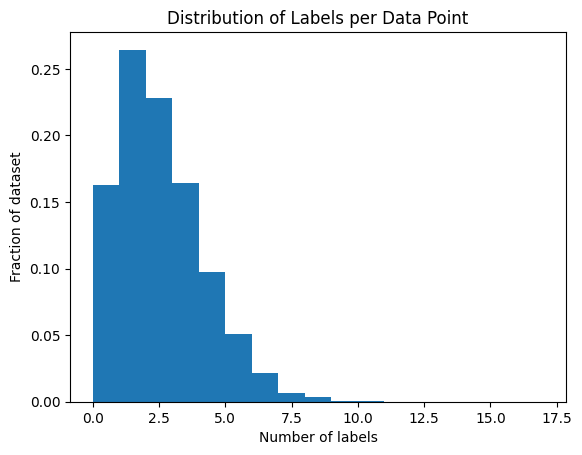

In [16]:
# Visualize label distribution
def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.title("Distribution of Labels per Data Point")
    plt.show()

plot_label_frequency(L_train)

## 4. Training the Label Model

In [17]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

100%|██████████| 500/500 [00:00<00:00, 2816.39epoch/s]


In [18]:
# Compare with majority vote baseline
from snorkel.labeling.model import MajorityLabelVoter

majority_model = MajorityLabelVoter()

majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   71.6%
Label Model Accuracy:     66.8%


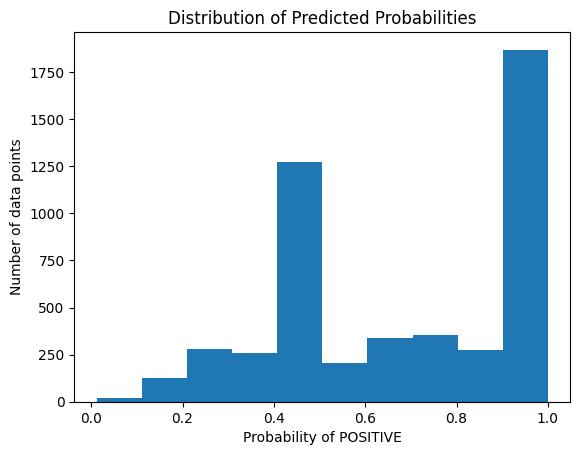

In [19]:
# Get probabilistic training labels
probs_train = label_model.predict_proba(L=L_train)

def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of POSITIVE")
    plt.ylabel("Number of data points")
    plt.title("Distribution of Predicted Probabilities")
    plt.show()

plot_probabilities_histogram(probs_train[:, POSITIVE])

In [20]:
# Filter out unlabeled data points
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

print(f"Filtered training set size: {len(df_train_filtered)}")
print(f"Coverage: {len(df_train_filtered) / len(df_train) * 100:.1f}%")

Filtered training set size: 4185
Coverage: 83.7%


## 5. Training a Discriminative Classifier

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=10000)
X_train = vectorizer.fit_transform(df_train_filtered.text.tolist())
X_test = vectorizer.transform(df_test.text.tolist())

print(f"Feature matrix shape: {X_train.shape}")

Feature matrix shape: (4185, 10000)


In [22]:
from snorkel.utils import probs_to_preds

preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

In [26]:
from sklearn.ensemble import RandomForestClassifier

sklearn_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=123,
    n_jobs=-1
)
sklearn_model.fit(X=X_train, y=preds_train_filtered)

,n_estimators,100
,criterion,'gini'
,max_depth,20
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [27]:
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=Y_test) * 100:.1f}%")

Test Accuracy: 58.8%


In [28]:
# Show some predictions
from sklearn.metrics import classification_report, confusion_matrix

y_pred = sklearn_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(Y_test, y_pred, target_names=['Negative', 'Positive']))

print("\nConfusion Matrix:")
print(confusion_matrix(Y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.12      0.21       117
    Positive       0.56      1.00      0.72       133

    accuracy                           0.59       250
   macro avg       0.78      0.56      0.47       250
weighted avg       0.77      0.59      0.48       250


Confusion Matrix:
[[ 14 103]
 [  0 133]]
